In [96]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.io
import os
from datetime import datetime, timezone, timedelta

In [97]:

# Get the current time
current_time = datetime.now(timezone(timedelta(hours=1))).strftime("%Y-%m-%d_%H-%M")

# Create the folder
folder_name = os.path.join(os.getcwd(), current_time)

try:
    os.makedirs(folder_name)
    print(f"Folder '{folder_name}' created successfully!")
except FileExistsError:
    print(f"Folder '{folder_name}' already exists.")
except Exception as e:
    print(f"Error occurred while creating the folder: {e}")

Folder 'c:\Users\Wayne\Desktop\CUDI-contrast-ultrasound dispersion imaging\16_weekly_update_25022024\2024-02-26_21-50' created successfully!


In [98]:
def get_displacement_wave_equation_output(u_init: np.array, u_init_2: np.array, DX: float, DT: float, NT: int, rho: float, mu: float, eta:float,  n_padding: int, x_values:np.array):
    NX = len(u_init) + 2 * n_padding # Add padding to deal with boundary conditions
    padding = np.zeros(n_padding)

    a = (mu * DT**2) / (rho * DX**2) #linear constant
    b = (eta * DT) / (rho * DX**2) #viscous constant


    u = np.zeros((NX, NT))
    u[:, 0] = np.hstack((padding, u_init, padding)) #add padding to deal with boundary conditions

    #As the simulation can take quite a long time to calculate and might need to be done at very small increments, it can be useful to continue a previous simulation, using the last two results from the previous simulation.
    if u_init_2 is None:
        for x in range(1, NX-1):
            u_linear = a * (u[x+1, 0] - 2 * u[x, 0] + u[x-1, 0])
            u_viscous = 0
            u[x, 1] = u_linear + u_viscous + u[x, 0]
    else:
        u[:, 1] = np.hstack((padding, u_init_2, padding))

    for t in range(1, NT-1):
        for x in range(1, NX-1):
            u_linear = a * (u[x+1, t] - 2 * u[x, t] + u[x-1, t])
            u_viscous = b *  (u[x+1, t] - 2 * u[x, t] + u[x-1, t] - u[x+1, t-1] + 2 * u[x, t-1] - u[x-1, t-1])
            u[x, t+1] = u_linear + u_viscous  + 2 * u[x, t] - u[x, t-1]

    plt.xlabel('x')
    plt.ylabel('u')

    for t in range(0, NT, 100):
        plt.plot(x_values, u[:, t])

    return u



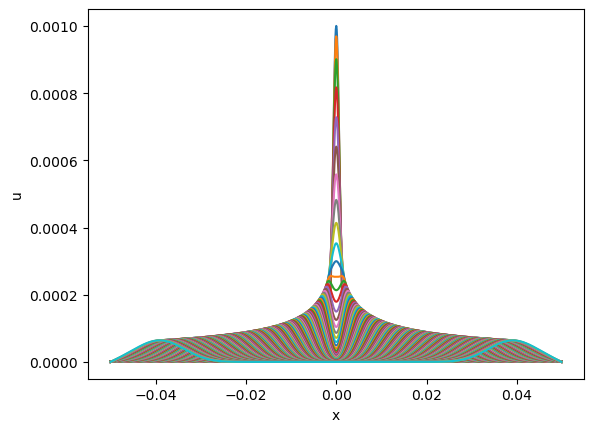

In [99]:
# Function to generate a Gaussian impulse

def gaussian(x):
    return f_amp * np.exp(-x**2 / sigma**2)

# Tissue parameters
eta = 1.5
mu = 4000
rho = 1000
n_padding = 0
# Simulation parameters
DX = 1e-4
DT = 1e-6
NT = 20000

# Spatial values
x_values = np.arange(-0.05, 0.05, DX)

# Parameters for Gaussian impulse
f_amp = 0.001
sigma = 0.001
u_init = np.zeros(len(x_values), dtype=np.float64)

for x in range(len(u_init)):
    u_init[x] = gaussian(x_values[x])

u = get_displacement_wave_equation_output(u_init=u_init, u_init_2=None, DX=DX, DT=DT, NT=NT, rho=rho, mu=mu, eta=eta, n_padding=n_padding, x_values=x_values)


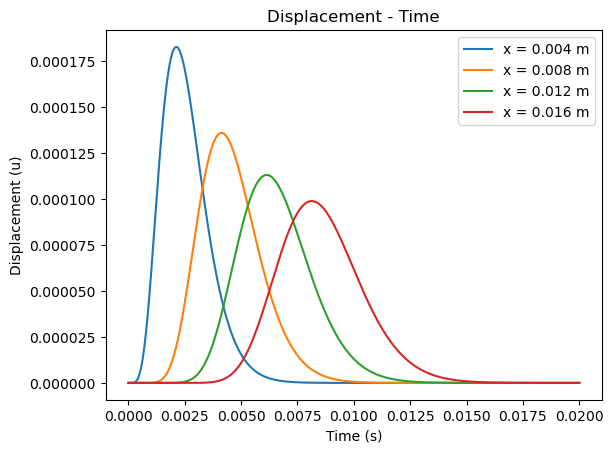

In [101]:
# Calculate time values
# Create a single figure
fig, ax = plt.subplots()
time_values = np.arange(0, u.shape[1] * DT, DT)

# Find the indices corresponding to the desired positions
x_positions = [0.004, 0.008, 0.012, 0.016]
x_indices = [int((x - x_values[0]) / DX) for x in x_positions]

# Select the corresponding u values for each position
u_at_positions = [u[x_index, :] for x_index in x_indices]

# Plot the selected u values against time values for each position
for i, u_at_position in enumerate(u_at_positions):
    plt.plot(time_values, u_at_position, label=f'x = {x_positions[i]} m')

# Add legend
plt.legend()

# Add labels and title
plt.xlabel('Time (s)')
plt.ylabel('Displacement (u)')
plt.title('Displacement - Time')
fig.savefig(os.path.join(folder_name, 'Prediction.png'))
# Show the plot
plt.show()


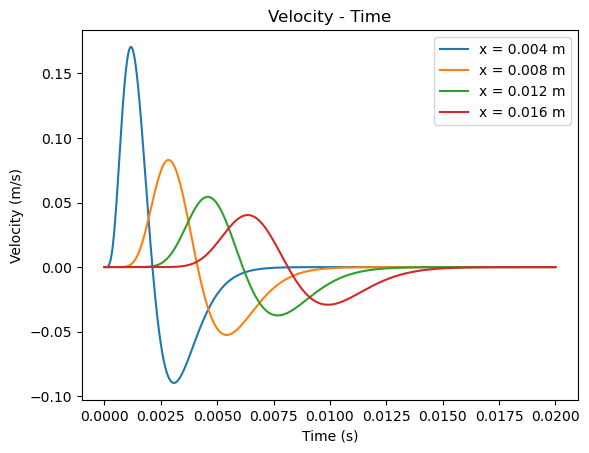

In [102]:
# Calculate velocity values (first derivative of displacement)
velocity_at_positions = [np.gradient(u_at_position, DT) for u_at_position in u_at_positions]

# Plot the selected velocity values against time values for each position
for i, velocity_at_position in enumerate(velocity_at_positions):
    plt.plot(time_values, velocity_at_position, label=f'x = {x_positions[i]} m')

# Add legend
plt.legend()

# Add labels and title
plt.xlabel('Time (s)')
plt.ylabel('Velocity (m/s)')
plt.title('Velocity - Time')

# Show the plot
plt.show()

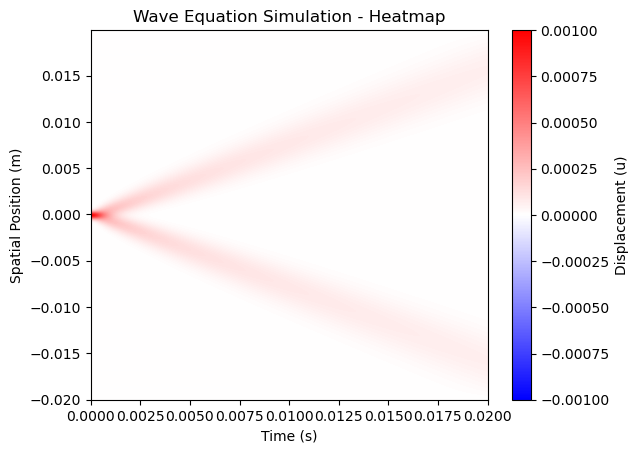

In [103]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
# Create a new figure for the heatmap

fig, ax = plt.subplots()
# Define spatial values
spatial_values = np.arange(-0.02, 0.02, DX)

# Create a transposed version of u
u_transposed = u

# Determine color mapping range
vmin = np.min(u_transposed)
vmax = np.max(u_transposed)

# Determine the absolute maximum value
abs_max = max(abs(vmin), abs(vmax))

# Create custom colormap
colors = [(0, 'blue'), (0.5, 'white'), (1, 'red')]  # Blue to White to Red colormap
cmap = LinearSegmentedColormap.from_list('custom_cmap', colors)



# Plot the heatmap
plt.imshow(
    u_transposed,
    extent=[0, NT * DT, spatial_values[0], spatial_values[-1]],
    aspect='auto',
    cmap=cmap,
    vmin=-abs_max,
    vmax=abs_max
)

# Add colorbar
plt.colorbar(label='Displacement (u)')

# Set labels and title
plt.xlabel('Time (s)')
plt.ylabel('Spatial Position (m)')
plt.title('Wave Equation Simulation - Heatmap')

plt.show()
fig.savefig(os.path.join(folder_name, 'Heatmap.png'))